Install dependencies and setup Kaggle and Upload your kaggle.json credentials file

In [ ]:
!pip install kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"mohamedabolyazeed","key":"6658410e2d980c97107f323553aae768"}'}

Set up Kaggle credentials

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Download the Flickr8k dataset

In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
flickr8k.zip: Skipping, found more recently modified local copy (use --force to force download)


Extract the dataset

In [ ]:
!unzip flickr8k.zip -d flickr8k

Import necessary libraries

In [ ]:
import numpy as np      # For array operations and fast mathematical computations
import pandas as pd     # For processing and analyzing tabular data (e.g., Excel or CSV files)
import os               # For interacting with the operating system (files, directories, paths)
import tensorflow as tf # For building and training AI/deep learning models
from tqdm import tqdm   # For displaying a progress bar during loops
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer # For converting text into sequences of tokens (useful for NLP tasks)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

Load the image

In [75]:
image_path = '/content/flickr8k/Images'

Load the caotions

In [76]:
captions_path = "/content/flickr8k/captions.txt"
data = pd.read_csv(captions_path)
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

Define helper functions for image display

In [77]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    n = 0
    for i in range(15):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        image = readImage(f"/content/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

Visualization Display some sample images with captions

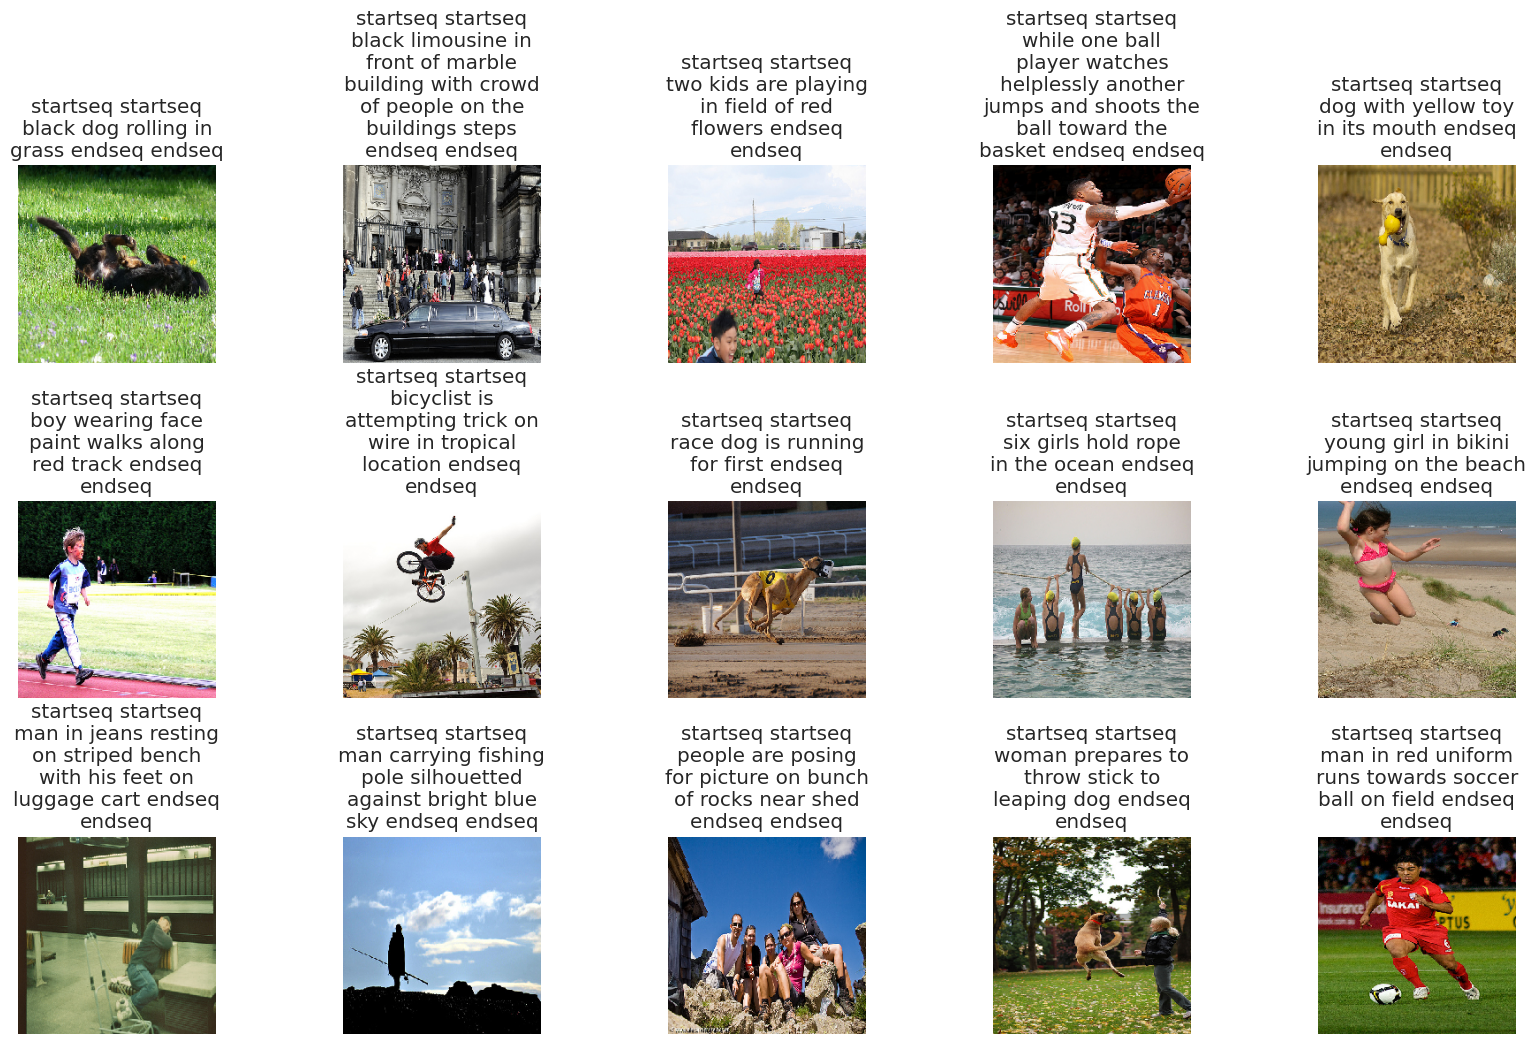

In [113]:
display_images(data.sample(15))

Caption Text Preprocessing

In [ ]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

Preprocessed Text

In [81]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
print("Sample processed captions:")
for i in range(10):
    print(captions[i])

Sample processed captions:
startseq startseq child in pink dress is climbing up set of stairs in an entry way endseq endseq
startseq startseq girl going into wooden building endseq endseq
startseq startseq little girl climbing into wooden playhouse endseq endseq
startseq startseq little girl climbing the stairs to her playhouse endseq endseq
startseq startseq little girl in pink dress going into wooden cabin endseq endseq
startseq startseq black dog and spotted dog are fighting endseq endseq
startseq startseq black dog and tri-colored dog playing with each other on the road endseq endseq
startseq startseq black dog and white dog with brown spots are staring at each other in the street endseq endseq
startseq startseq two dogs of different breeds looking at each other on the road endseq endseq
startseq startseq two dogs on pavement moving toward each other endseq endseq


Tokenization and Encoded Representation

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

print(f"Vocabulary Size: {vocab_size}")
print(f"Maximum Sequence Length: {max_length}")

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

print(f"Number of training images: {len(train_images)}")
print(f"Number of validation images: {len(val_images)}")

Vocabulary Size: 8485
Maximum Sequence Length: 36
Number of training images: 6877
Number of validation images: 1214


Image Feature Extraction

In [ ]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)
img_size = 224

image_dir = image_path

features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 8091/8091 [1:01:09<00:00,  2.20it/s]


Data Generation

In [ ]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y


train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

Modelling

In [115]:
from tensorflow.keras.utils import plot_model

input1 = Input(shape=(1920,))   # Feature image with DenseNet201
input2 = Input(shape=(max_length,)) # captions

img_features = Dense(256, activation='relu')(input1) # convert image feature
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features) # convert image feature

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2) # Comment processing
merged = concatenate([img_features_reshaped,sentence_features],axis=1) # Combine image and comment features
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features) # Reduce overfitting
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')


from tensorflow.keras.callbacks import ModelCheckpoint

# Define the model checkpoint
model_name = "model.keras"  # Update the extension to .keras
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

history = caption_model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 5.0076
Epoch 1: val_loss improved from inf to 3.64147, saving model to model.keras
505/505 ━━━━━━━━━━━━━━━━━━━━ 1466s 3s/step - loss: 5.0063 - val_loss: 3.6415 - learning_rate: 0.0010
Epoch 2/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 3.6822
Epoch 2: val_loss improved from 3.64147 to 3.34474, saving model to model.keras
505/505 ━━━━━━━━━━━━━━━━━━━━ 1475s 3s/step - loss: 3.6820 - val_loss: 3.3447 - learning_rate: 0.0010
Epoch 3/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 3.4083
Epoch 3: val_loss improved from 3.34474 to 3.20154, saving model to model.keras
505/505 ━━━━━━━━━━━━━━━━━━━━ 1504s 3s/step - loss: 3.4083 - val_loss: 3.2015 - learning_rate: 0.0010
Epoch 4/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 3.2481
Epoch 4: val_loss improved from 3.20154 to 3.10768, saving model to model.keras
505/505 ━━━━━━━━━━━━━━━━━━━━ 1474s 3s/step - loss: 3.2481 - val_loss: 3.1077 - learning_rate: 0.0010
Epoch 5/10
505/5

Learning Curve

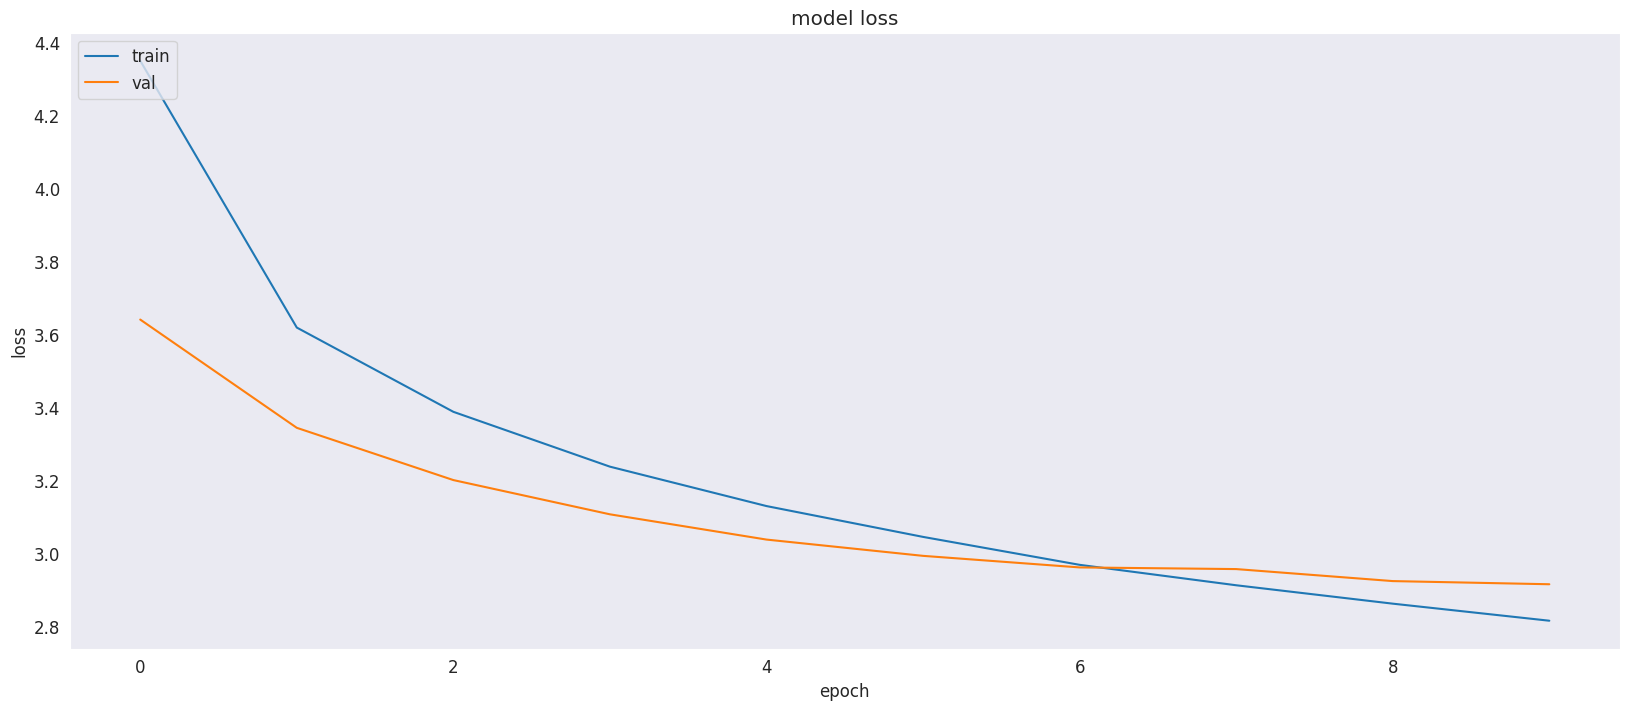

In [119]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Caption Generation Utility Functions

In [120]:
import pickle

# Save the tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save the feature extractor model
# Assign the 'fe' variable (which was used for feature extraction) to 'feature_extractor'
feature_extractor = fe
feature_extractor.save("feature_extractor.keras")

In [121]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle

# load save files
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"


def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=36, img_size=224): # max_length updated to 36 to match training
    # Load the trained models and tokenizer
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Preprocess the image
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)
    image_features = feature_extractor.predict(img, verbose=0)  # Extract image features

    # Generate the caption
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break
    caption = in_text.replace("startseq", "").replace("endseq", "").strip()

    # Display the image with the generated caption
    img = load_img(image_path, target_size=(img_size, img_size))
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='blue')
    plt.show()

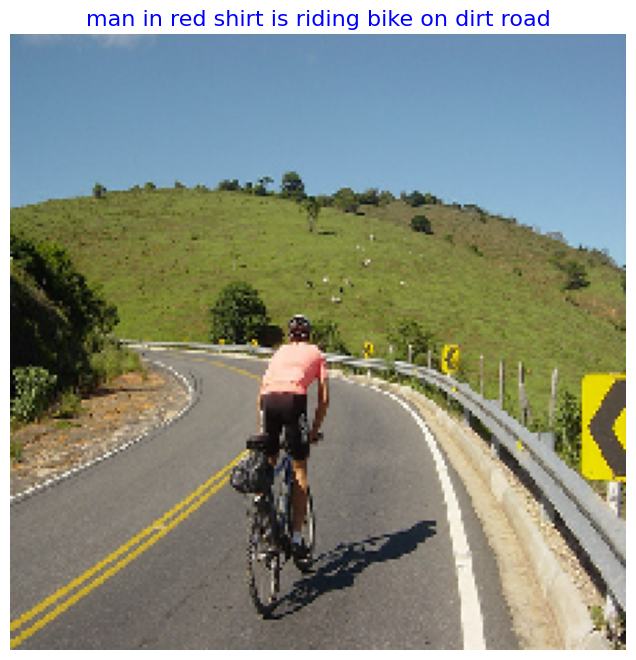

In [122]:
# Example usage
image_path = "/content/flickr8k/Images/110595925_f3395c8bd6.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

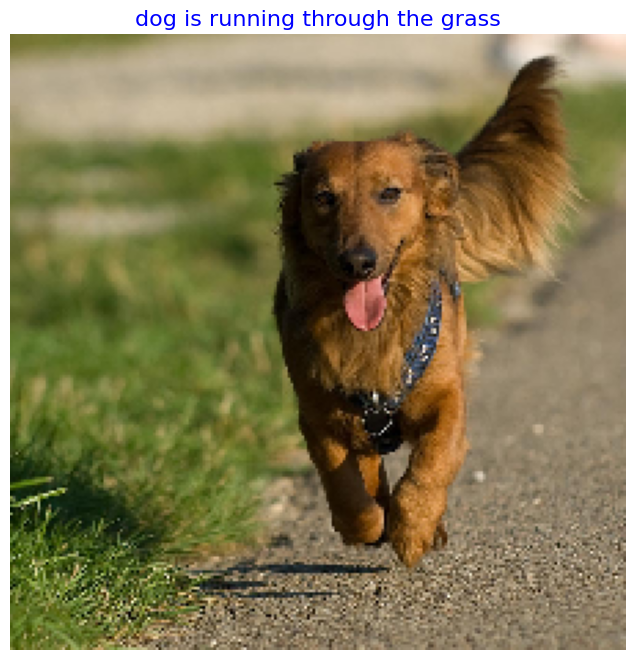

In [125]:
image_path = "/content/flickr8k/Images/1089181217_ee1167f7af.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

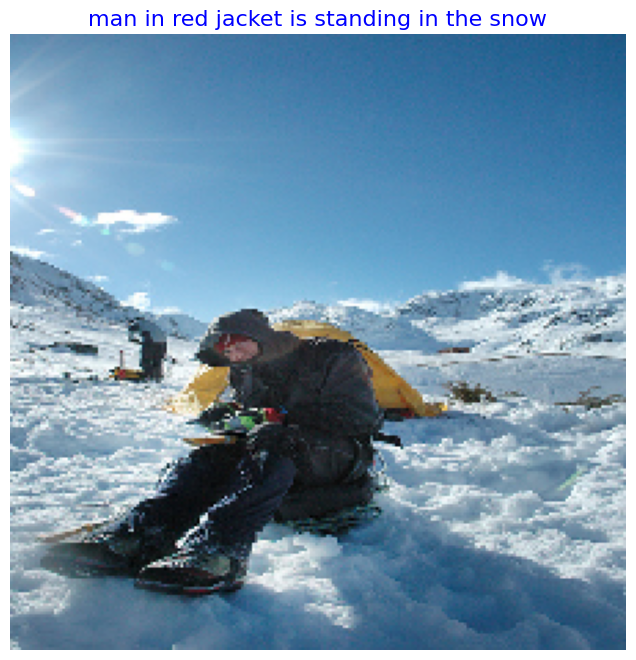

In [124]:
image_path = "/content/flickr8k/Images/116409198_0fe0c94f3b.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

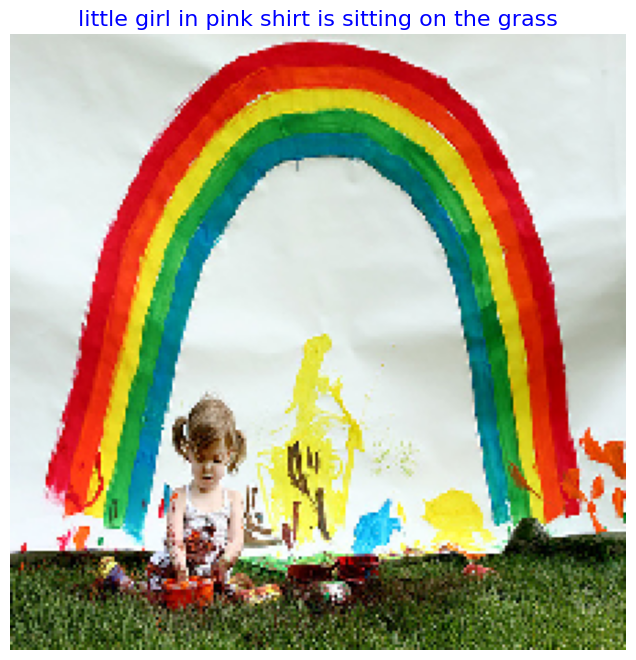

In [123]:
# Example usage
image_path = "/content/flickr8k/Images/1002674143_1b742ab4b8.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)